# Variational autoencoder

This example demostrates the implementation of a Variational Autoencoder in JAX, from scratch.

Specifically, it showcases:

  - Some possible architehture for the encoder and decoder. Note it could be improved by the addition of convolutional layers.
  - The optimization of the ELBO loss function using backpropagation, including across the random input.
  - The use of the trained models as image generators.
  
The exercise is repeated for a conditional variational autoencoder, where both encoder and decoder take a(one-hot encoded) label as input. The pre trained encoder in the previous step is used to try to improve the learning process. This does not seem to work so well.

The optimization runs for quite a while, but it can be interrupted at any time, with the current parameters being availaible for later use and inspection.

Optional extensions:

  - Try using a different dataset, such as CIFAR10.
  - Try playing around with the architechture and parameter settings, such as the latent dimenstion.
  - Study the distances in the latent space for images with the same and different labels.
  - Investigate why does the pre trained encoder work much less well than expected (i.e. it starts with a higher loss despite the extra information contained in the label and takes more to converge).
  - Try adding de-noising capablitied to the model.
  - Try using a different optimizer library, such as optax.
  - At the moment we are not using the test data. How could it be used to assess the model?
  



In [26]:
import itertools
import array
import gzip
import os
from os import path
import struct
import urllib.request
import tempfile

import numpy as np
import matplotlib.pyplot as plt



import jax
import jax.numpy as jnp
from jax import grad, jit, random

from jax.nn.initializers import he_normal
from jax.nn import sigmoid, softmax
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, Sigmoid, Softplus



# Data downloading code

In [2]:
_DATA_PATH = tempfile.mkdtemp(prefix="mnist_data")


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA_PATH):
        os.makedirs(_DATA_PATH)
    out_file = path.join(_DATA_PATH, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print(f"downloaded {url} to {_DATA_PATH}")


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(
                num_data, rows, cols
            )

    for filename in [
        "train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA_PATH, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA_PATH, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA_PATH, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA_PATH, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist():
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.0)
    test_images = _partial_flatten(test_images) / np.float32(255.0)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    return (
        train_images,
        train_labels,
        test_images,
        test_labels,

    )


#### Download the data and set dimensions

In [3]:

img_shape = (28, 28)

flat_img_shape = np.prod(img_shape)

n_cat = 10


train_data, train_labels, test_data, test_labels = mnist()


downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/mnist_datakk5mkycw
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/mnist_datakk5mkycw
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/mnist_datakk5mkycw
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/mnist_datakk5mkycw


## Model definition

In [4]:
latent_dim = 20

# Define the VAE architecture
def vae_model(latent_dim):
    # Encoder
    encoder_init, encoder_apply = stax.serial(
        Dense(512, W_init=he_normal()), Relu,
        Dense(256, W_init=he_normal()), Relu,
        Dense(2 * latent_dim)  # Output will be mean and log-variance of the latent space
    )

    # Decoder
    decoder_init, decoder_apply = stax.serial(
        Dense(256, W_init=he_normal()), Relu,
        Dense(512, W_init=he_normal()), Relu,
        Dense(flat_img_shape), Sigmoid  # Output size is 28*28 (MNIST image size)
    )

    return encoder_init, encoder_apply, decoder_init, decoder_apply

#### Initialize the VAE model


In [5]:
encoder_init, encoder_apply, decoder_init, decoder_apply = vae_model(latent_dim)

#### Initialize random state

In [6]:
rng = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


#### Initialize the parameters 

In [7]:
_shape, encoder_params = encoder_init(rng, (-1, 784))
_shape, decoder_params = decoder_init(rng, (-1, latent_dim))

# Combine the encoder and decoder parameters
vae_params = (encoder_params, decoder_params)


## Loss definition

In [8]:
def vae_loss(params, data, rng):
    encoder_params, decoder_params = params

    encoder_values = encoder_apply(encoder_params, data)
    
    # Split the encoded data into mean and log-variance
    mean, log_var = encoder_values[:, :latent_dim], encoder_values[:, latent_dim:]
    

    # Reparameterization trick to sample from the latent space
    epsilon = random.normal(rng, mean.shape)
    z = mean + jnp.exp(0.5 * log_var) * epsilon

    # Reconstruct the data
    reconstruction = decoder_apply(decoder_params, z)
    

    reconstruction_loss = -jnp.sum(
        data * jnp.log(reconstruction + 1e-8)
        + (1 - data) * jnp.log(1 - reconstruction + 1e-8)
    )
    
    # Compute KL divergence between the latent space distribution and the prior, N(0,1)
    kl_divergence = -0.5 * jnp.sum(1 + log_var - mean**2 - jnp.exp(log_var))

    # Total loss is the sum of reconstruction loss and KL divergence
    total_loss = (reconstruction_loss + kl_divergence)/len(data)

    return total_loss

## Optimization

#### Optimization settings

In [9]:
num_epochs = 150
batch_size = 64


step_size = 0.0004
momentum_mass = 0.9

#### Optimization initialization

In [10]:



itercount = itertools.count()

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
opt_state = opt_init(vae_params)

#### Updating rule

In [11]:
@jit
def update(i, opt_state, data, rng):
    params = get_params(opt_state)
    return opt_update(i, grad(vae_loss)(params, data, rng), opt_state)

#### Data stream

We take care of randomizing the order of the data in each iteration, so as to not bias the optimization towards the latest data.

In [12]:
def data_stream(rng):
    while True:
        rng, subkey = random.split(rng)
        perm = random.permutation(subkey, jnp.arange(num_train))
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield train_data[batch_idx]
            
rng, subkey = random.split(rng)           
batches = data_stream(subkey)

num_train = train_data.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)


## Training loop

In [13]:
for epoch in range(num_epochs):
    for _ in range(num_batches):
        rng, subkey = jax.random.split(rng)
        opt_state = update(next(itercount), opt_state, next(batches), subkey)


    # Calculate and print the reconstruction loss at the end of each epoch
    vae_params = get_params(opt_state)
    rng, subkey = jax.random.split(rng)
    # Note: It is important to make sure we are sampling 
    # different random numbers at each iteration.
    loss = vae_loss(vae_params, train_data, subkey)
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {loss}")

Epoch 1/150, Total Loss: 132.1481475830078
Epoch 2/150, Total Loss: 120.81501007080078
Epoch 3/150, Total Loss: 116.92743682861328
Epoch 4/150, Total Loss: 114.57603454589844
Epoch 5/150, Total Loss: 112.78033447265625
Epoch 6/150, Total Loss: 111.80286407470703
Epoch 7/150, Total Loss: 111.17925262451172
Epoch 8/150, Total Loss: 109.7723617553711
Epoch 9/150, Total Loss: 108.79523468017578
Epoch 10/150, Total Loss: 108.63961029052734
Epoch 11/150, Total Loss: 108.05463409423828
Epoch 12/150, Total Loss: 107.48576354980469
Epoch 13/150, Total Loss: 106.82023620605469
Epoch 14/150, Total Loss: 106.33717346191406
Epoch 15/150, Total Loss: 106.43558502197266
Epoch 16/150, Total Loss: 105.80220794677734
Epoch 17/150, Total Loss: 105.35298156738281
Epoch 18/150, Total Loss: 105.31351470947266
Epoch 19/150, Total Loss: 105.10684967041016
Epoch 20/150, Total Loss: 104.85519409179688
Epoch 21/150, Total Loss: 104.57330322265625
Epoch 22/150, Total Loss: 104.26589965820312
Epoch 23/150, Total L

## Plot resulting samples

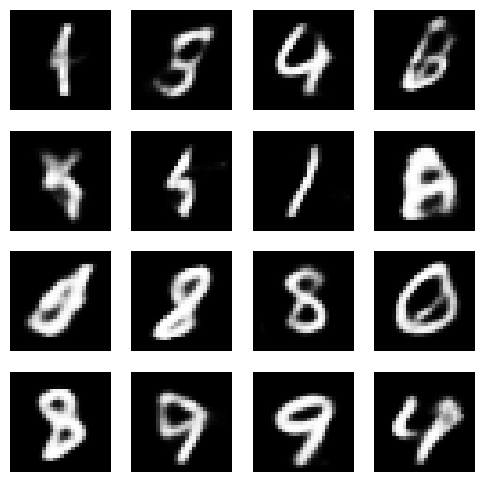

In [14]:

def generate_samples(params, rng, num_samples=16):
    latent_samples = random.normal(rng, (num_samples, latent_dim))
    generated_images = decoder_apply(params[1], latent_samples)
    return generated_images

rng, subkey = random.split(rng)
generated_images = generate_samples(vae_params, subkey)

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.reshape(generated_images[i], img_shape), cmap="gray")
    ax.axis('off')
plt.show()

### Explore a cross section of the latent space

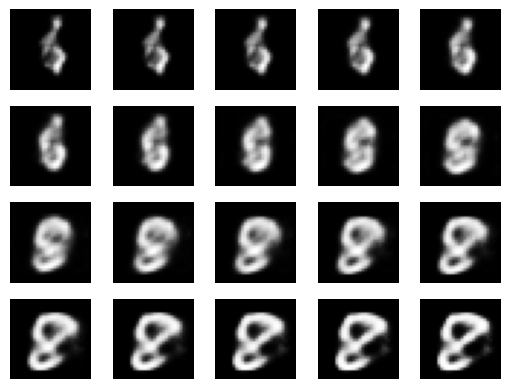

In [15]:
num_samples = 20
latent_samples = jnp.tile(jnp.linspace(-1, 1, num_samples)[:, None], (1, latent_dim))
generated_images = decoder_apply(vae_params[1], latent_samples)

fig, axs = plt.subplots(4, num_samples//4)

for img, ax in zip(generated_images, axs.ravel()):
    ax.imshow(img.reshape(img_shape), cmap="gray")
    ax.axis('off')

## Conditional variational autoencoder

In [16]:
pretrained_encoder_params = encoder_params[:-1]

In [17]:
_init, pretrained_encoder_apply = stax.serial(
        Dense(512, W_init=he_normal()), Relu,
        Dense(256, W_init=he_normal()), Relu,)

In [18]:
def cond_vae_model(latent_dim):
    # Encoder
    encoder_init, encoder_apply = stax.serial(
        Dense(50, W_init=he_normal()), Relu,
        Dense(2 * latent_dim)  # Output will be mean and log-variance of the latent space
    )

    # Decoder
    decoder_init, decoder_apply = stax.serial(
        Dense(256, W_init=he_normal()), Relu,
        Dense(512, W_init=he_normal()), Relu,
        Dense(flat_img_shape), Sigmoid,  # We output a prediction for the image and the category
    )

    return encoder_init, encoder_apply, decoder_init, decoder_apply

In [19]:
(
    cond_encoder_init, 
    cond_encoder_apply, 
    cond_decoder_init, 
    cond_decoder_apply
) = cond_vae_model(latent_dim)

_shape, cond_encoder_params = cond_encoder_init(rng, (-1, 256+n_cat))
_shape, cond_decoder_params = cond_decoder_init(rng, (-1, latent_dim+n_cat))

# Combine the encoder and decoder parameters
cond_vae_params = (cond_encoder_params, cond_decoder_params)


In [20]:
#def process_decoder_output(out):
#    return sigmoid(out[:, :flat_img_shape]), softmax(out[:, flat_img_shape:])

In [21]:
def cond_vae_loss(params, data, rng):
    images, labels = data
    

    
    
    encoder_params, decoder_params = params
    
    encoded_images = pretrained_encoder_apply(pretrained_encoder_params, images)
    inp = jnp.concatenate([encoded_images, labels],  axis=1)

    encoder_values = cond_encoder_apply(encoder_params, inp)
    
    # Split the encoded data into mean and log-variance
    mean, log_var = encoder_values[:, :latent_dim], encoder_values[:, latent_dim:]
    

    # Reparameterization trick to sample from the latent space
    epsilon = random.normal(rng, mean.shape)
    z = mean + jnp.exp(0.5 * log_var) * epsilon
    
    decoder_inp = jnp.concatenate([z, labels], axis=1)

    # Reconstruct the data
    reconstruction_img = cond_decoder_apply(decoder_params, decoder_inp)
    #reonstruction_img, reconstruction_label = process_decoder_output(reconstruction_input)
    
    

    reconstruction_loss = -jnp.sum(
        images * jnp.log(reconstruction_img + 1e-8)
        + (1 - images) * jnp.log(1 - reconstruction_img + 1e-8)
    )
    
    #classification_loss = -np.sum(labels * jnp.log(reconstruction_label + 1e-8))
    
    
    
    # Compute KL divergence between the latent space distribution and the prior, N(0,1)
    kl_divergence = -0.5 * jnp.sum(1 + log_var - mean**2 - jnp.exp(log_var))

    # Total loss is the sum of reconstruction loss and KL divergence
    total_loss = (reconstruction_loss + kl_divergence )/len(images)

    return total_loss

In [22]:




cond_num_epochs = 150
cond_batch_size = 64


cond_step_size = 0.0002
cond_momentum_mass = 0.9




(
    cond_opt_init, 
    cond_opt_update, 
    cond_get_params
) = optimizers.momentum(cond_step_size, mass=cond_momentum_mass)
    

cond_opt_state = cond_opt_init(cond_vae_params)



@jit
def cond_update(i, opt_state, data, rng):
    params = cond_get_params(opt_state)
    return cond_opt_update(i, grad(cond_vae_loss)(params, data, rng), opt_state)

def joint_data_stream(rng):
    while True:
        rng, subkey = random.split(rng)
        perm = random.permutation(subkey, jnp.arange(num_train))
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield train_data[batch_idx], train_labels[batch_idx]

rng, subkey = random.split(rng)
joint_batches = joint_data_stream(subkey)

cond_num_train = train_data.shape[0]
cond_num_complete_batches, leftover = divmod(num_train, batch_size)
cond_num_batches = num_complete_batches + bool(leftover)


In [23]:
cond_itercount = itertools.count()

for epoch in range(num_epochs):
    for _ in range(num_batches):
        rng, subkey = jax.random.split(rng)
        cond_opt_state = cond_update(next(cond_itercount), cond_opt_state, next(joint_batches), subkey)


    # Calculate and print the reconstruction loss at the end of each epoch
    cond_vae_params = cond_get_params(cond_opt_state)
    rng, subkey = jax.random.split(rng)
    # Note: It is important to make sure we are sampling 
    # different random numbers at each iteration.
    loss = cond_vae_loss(cond_vae_params, (train_data, train_labels), subkey)
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {loss}")

Epoch 1/150, Total Loss: 159.6698760986328
Epoch 2/150, Total Loss: 145.37921142578125
Epoch 3/150, Total Loss: 138.27134704589844
Epoch 4/150, Total Loss: 133.83343505859375
Epoch 5/150, Total Loss: 130.72897338867188
Epoch 6/150, Total Loss: 128.11331176757812
Epoch 7/150, Total Loss: 126.3009033203125
Epoch 8/150, Total Loss: 124.47100067138672
Epoch 9/150, Total Loss: 123.25323486328125
Epoch 10/150, Total Loss: 122.12284851074219
Epoch 11/150, Total Loss: 121.0156021118164
Epoch 12/150, Total Loss: 120.47565460205078
Epoch 13/150, Total Loss: 119.58583068847656
Epoch 14/150, Total Loss: 118.85504913330078
Epoch 15/150, Total Loss: 118.26785278320312
Epoch 16/150, Total Loss: 118.01766204833984
Epoch 17/150, Total Loss: 117.49232482910156
Epoch 18/150, Total Loss: 117.29965209960938
Epoch 19/150, Total Loss: 116.56837463378906
Epoch 20/150, Total Loss: 116.20500183105469
Epoch 21/150, Total Loss: 115.69830322265625
Epoch 22/150, Total Loss: 115.4655532836914
Epoch 23/150, Total Los

In [28]:
desired_labels =  jnp.eye(10)
rng, subkey = random.split(rng)
noise_input = jax.random.normal(subkey, (10, latent_dim))

decoder_input  = jnp.concatenate([noise_input, desired_labels], axis=1)

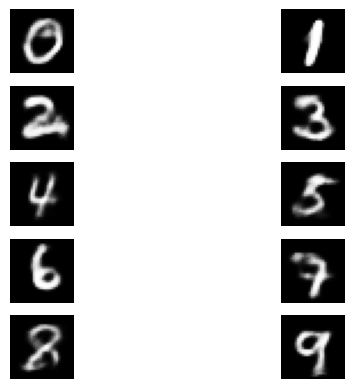

In [29]:
num_samples = 10
#latent_samples = jnp.tile(jnp.linspace(-1, 1, num_samples)[:, None], (1, latent_dim))
generated_images = cond_decoder_apply(cond_vae_params[1], decoder_input)

#generated_images = decoder_apply(vae_params[1], noise_input)

fig, axs = plt.subplots(5, num_samples//5 + num_samples%5)

for img, ax in zip(generated_images, axs.ravel()):
    ax.imshow(img.reshape(img_shape), cmap="gray")
    ax.axis('off')